# Capacitated Location Set Covering Problem (System Optimal) (CLSCP-SO)

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

Capacitated Location Set Covering (System Optimal) builds off of the [LSCP](https://pysal.org/spopt/notebooks/lscp.html), but allows for the assignment of a facility's capacity and the amount of demand at a demand point to be used in the siting of facilities. CLSCP can be described as follows:

_Locate just enough facilities and associated capacity such that all demand is served within the capacity limits of each facility, given the coverage capabilities of each facility._ Church L., Murray, A. (2018)

**CLSCP-SO can be written as:**

\begin{equation*}
\textbf{Minimize }\sum_{j \in J}  x_j
\end{equation*}

_Subject to:_
\begin{equation*}
\sum_{j\in N_i} z_{ij} = 1 \quad \forall i \in I
\end{equation*}

\begin{equation*}
\sum_{i\in I} a_i z_{ij} \leq C_jx_j \quad \forall j \in J
\end{equation*}

\begin{equation*}
x_j \in \{0,1\} \quad \forall j \in J
\end{equation*}

\begin{equation*}
z_{ij} \geq 0 \quad \forall i \in I, j \in N_i
\end{equation*}

_Where:_

\begin{array}{lclll}
& & i & \small = & \textrm{index of demand points/areas/objects (entire set denoted} \quad I \textrm{ )}\\
& & j & \small = & \textrm{index of potential facility sites (entire set denoted} \quad J \textrm{ )} \\
& & S & \small = & \textrm{desired maximal service standard (travel distance or time)} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between demand} \quad i \quad \textrm{and potential facility} \quad j \\
& & N_i & \small = & \{j | d_{ij} \leq S\} \\
& & \Psi_j & \small = & \{i | d_{ij} \leq S\} \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{amount of demand at} \quad i \\
& & C_j & \small = & \textrm{capacity of potential facility} \quad j \\
& & Z_{ij} & \small = & \textrm{fraction of demand} \quad i \quad \textrm{that is assigned to facility} \quad j \\
& & x_j & \small = & \begin{cases} 
          1, \quad \text{if a facility is located at} \quad j\\
          0, \quad \text{otherwise} \\
       \end{cases} \end{array}
       
_The excerpt above was quoted from Church L., Murray, A. (2018)_

This tutorial solves CLSCP-SO using `spopt.locate.coverage.LSCP` instance that depends on a array 2D representing the costs between facilities candidate sites and demand points. For that it uses a lattice 10x10 with simulated points to calculate the costs. A numpy array representing facility capacities as well as demand quantities is also required.

In [ ]:
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

Since the model needs a distance cost matrix we should define some variables. In the comments, it's defined what these variables are for but solver. The solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [2]:
CLIENT_COUNT = 5 # quantity demand points
FACILITY_COUNT = 2 # quantity supply points

SERVICE_RADIUS = 8 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5 
FACILITY_SEED = 6 

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create lattice 10x10 with 9 vertical lines in interior.

In [3]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform spaghetti instance into geodataframe.

In [4]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

Plotting the network created by spaghetti we can verify that it seems a district with quarters and streets.

<AxesSubplot: >

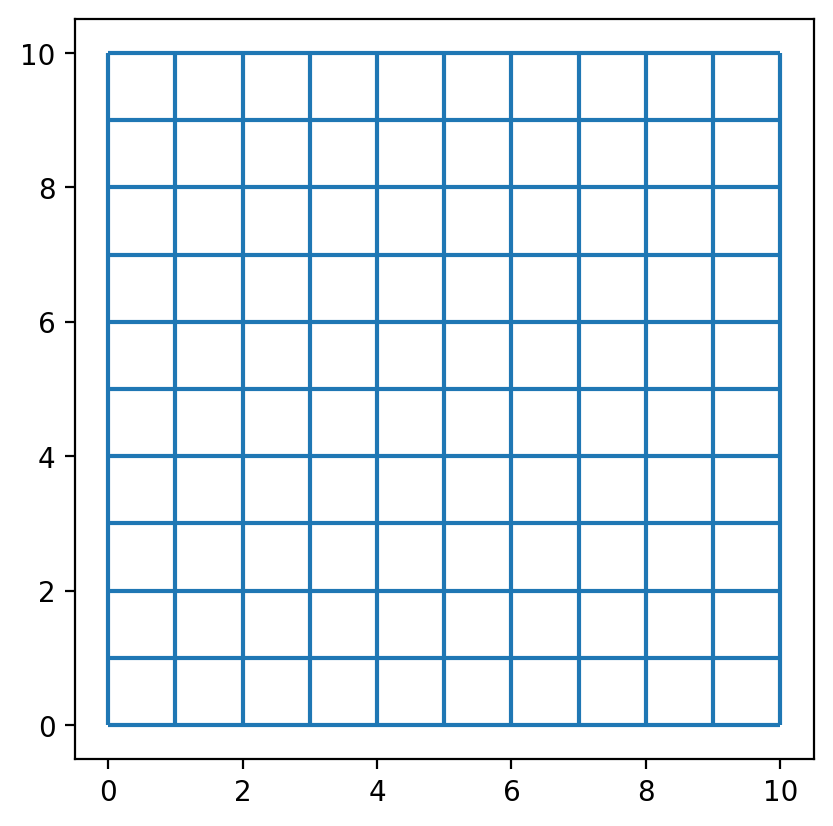

In [5]:
street.plot()

## Simulate points in a network

The function `simulated_geo_points` simulates points inside a network. In this case, it uses a lattice network 10x10 created by using spaghetti package. 
Below we use the function defined above and simulate the points inside lattice bounds.

In [6]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 5 client and 2 facility points we can see that the function generates dummy points to an area of 10x10 which is the area created by our lattice created on previous cells.

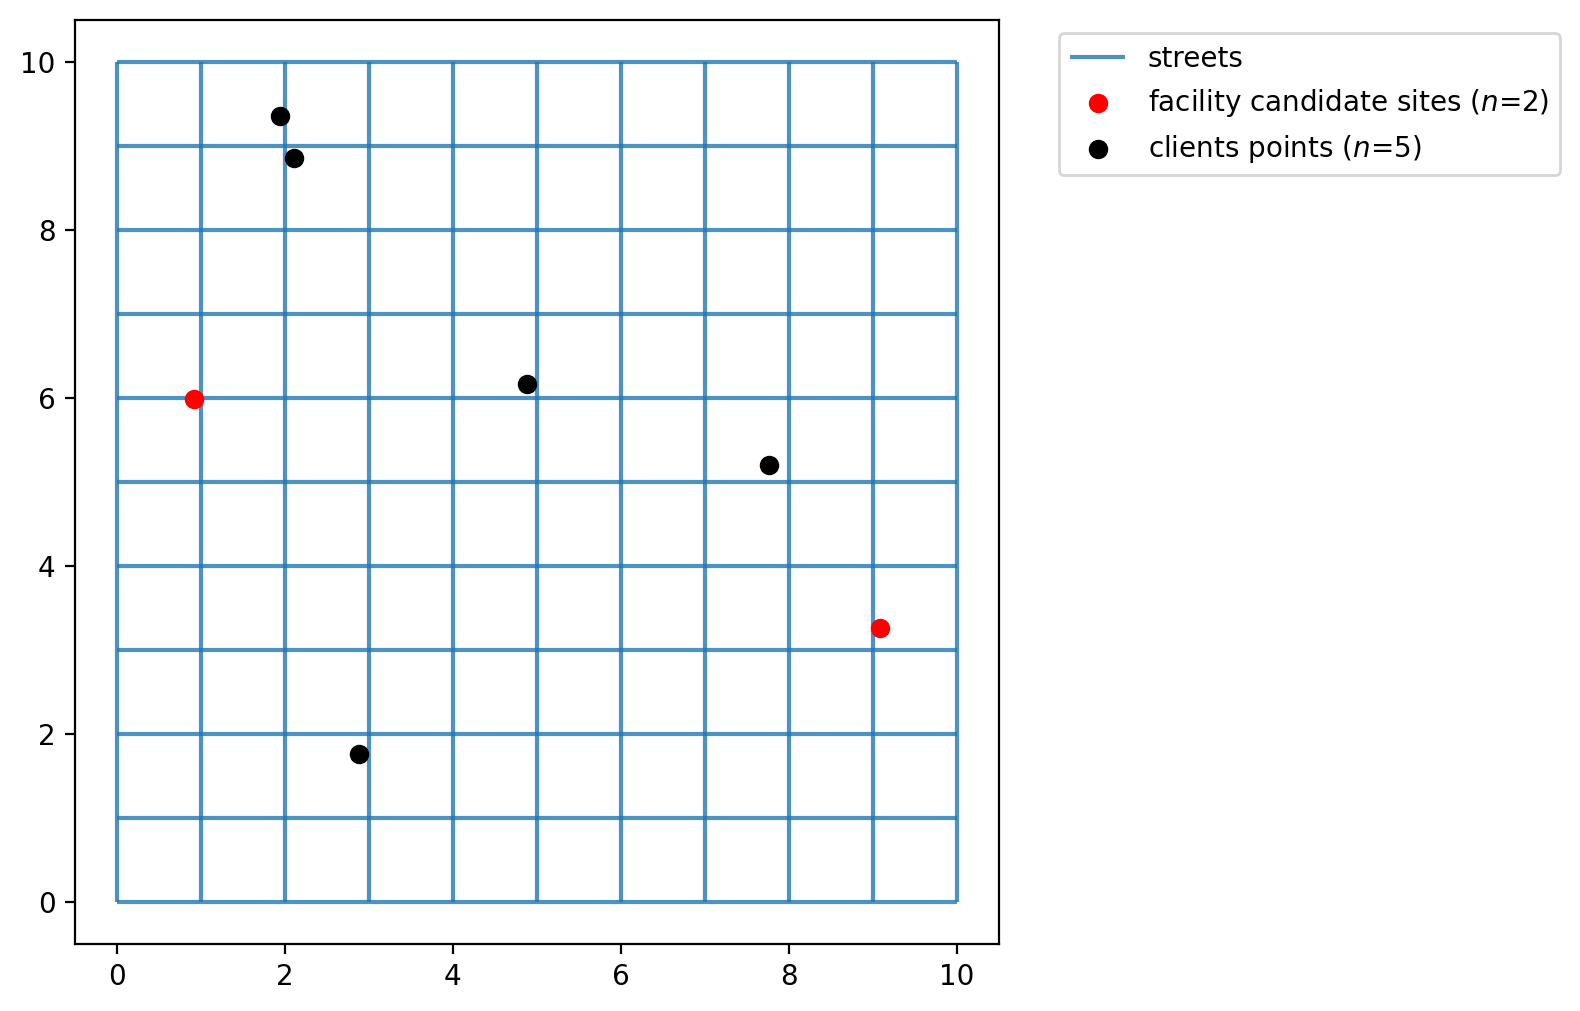

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=2)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=5)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Transform simulated points to real points

To use cost matrix or geodataframes we have to pay attention in some details. The client and facility points simulated don't belong to network, so if we calculate the distances now we are supposed to receive a wrong result. Before calculating distances we snap points to the networok and then calculate the distances.

Below we snap points that is not spatially belong to network and create new real points geodataframes

In [8]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)


Now the plot seems more organized as the points belong to network. 
The network created is plotted below with facility points and clients points:

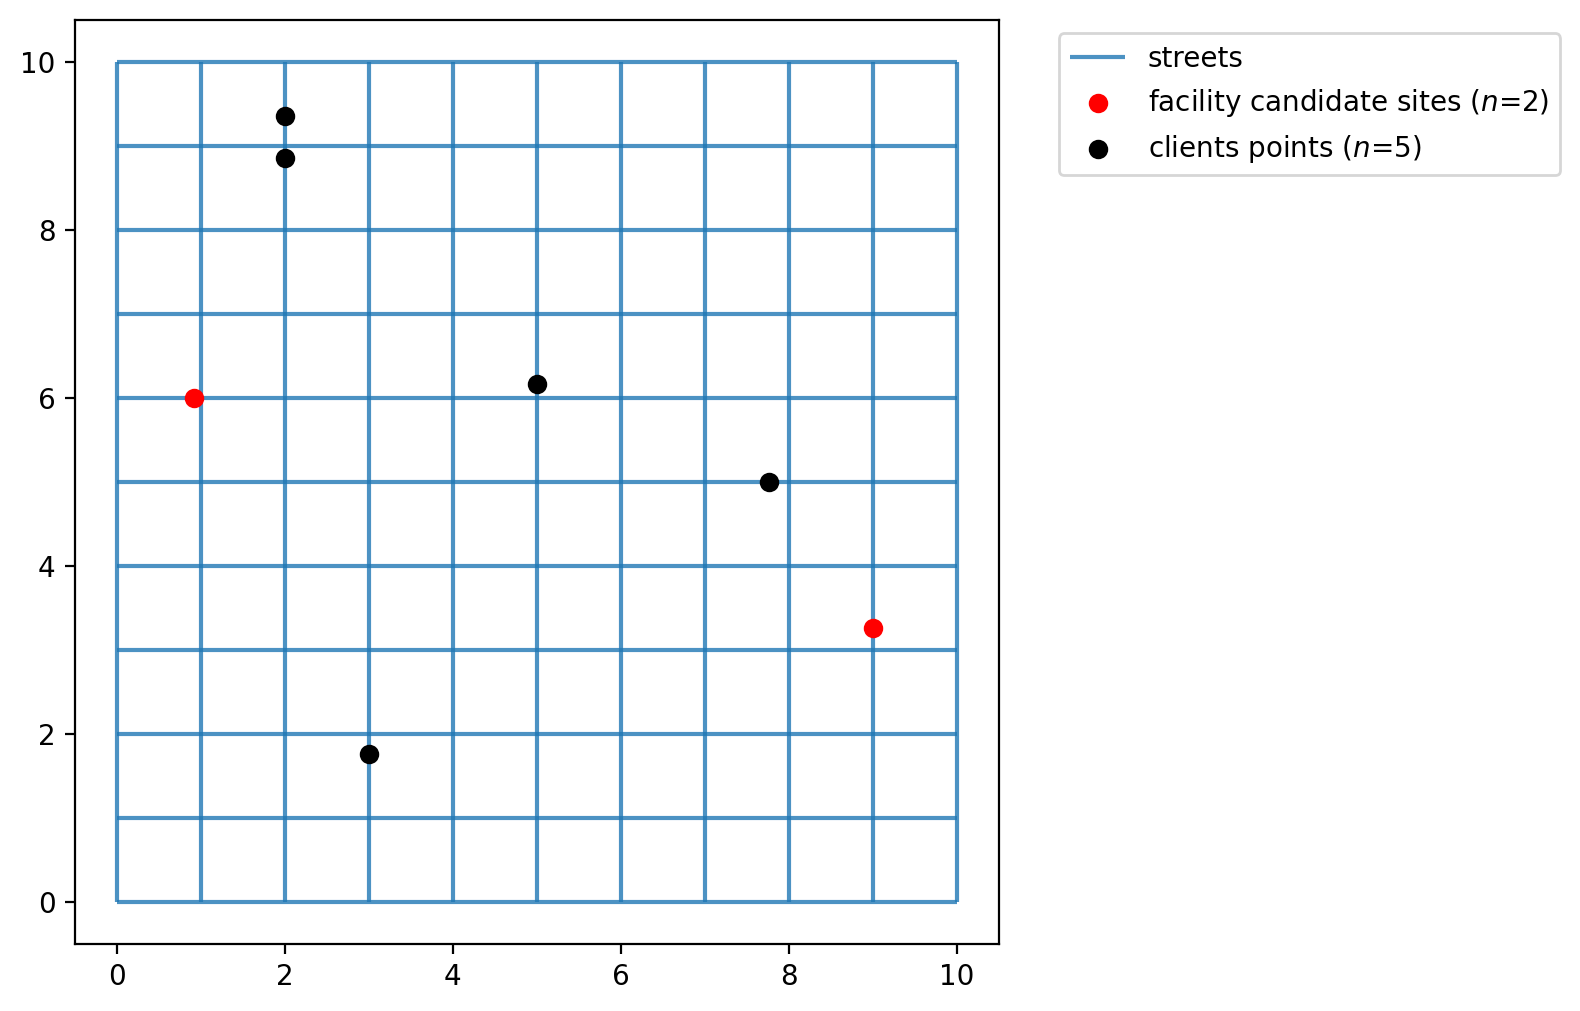

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=2)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=5)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Calculating the cost matrix 

Calculate distance between clients and facilities.

In [10]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

The expected result here is a Dijkstra distance between clients and facilities points, so we our case an array 2D 5x2.

In [11]:
cost_matrix

array([[12.60302601,  3.93598651],
       [13.10096347,  4.43392397],
       [ 6.9095462 ,  4.2425067 ],
       [ 2.98196832,  7.84581224],
       [ 7.5002892 ,  6.32806975]])

By manipulating the facility capacity array we can demonstrate how capacity is accounted for and generate different results. We'll do this using three different "scenarios" where the two sites have different capacities. In the first case, the first supply facility has a smaller capacity to service demand points. In the second case, the *second* supply has a smaller capacity. Finally, we provide a case where both sites have the same capacity.  

In [12]:
facility_capacity = numpy.array([5, 15])
facility_capacity_switched = numpy.array([15, 5])
facility_capacity_even = numpy.array([8, 8])
facility_capacity, facility_capacity_switched, facility_capacity_even

(array([ 5, 15]), array([15,  5]), array([8, 8]))

The sum of demand quantity is 15, so the problem should be feasible in all cases. We know this because the "capacity" of the system is always greater than the demand in the system. 

In [13]:
demand_quantity = numpy.arange(1, 6)
demand_quantity

array([1, 2, 3, 4, 5])

With ``LSCP.from_cost_matrix`` we model CLSC problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using cost matrix calculated previously.

In [14]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(
    cost_matrix, SERVICE_RADIUS, facility_capacity_arr=facility_capacity, demand_quantity_arr=demand_quantity)
lscp_from_cost_matrix = lscp_from_cost_matrix.solve(solver)

In [15]:
lscp_from_cost_matrix_switched = LSCP.from_cost_matrix(
    cost_matrix, SERVICE_RADIUS, facility_capacity_arr=facility_capacity_switched, demand_quantity_arr=demand_quantity)
lscp_from_cost_matrix_switched = lscp_from_cost_matrix_switched.solve(solver)

In [16]:
lscp_from_cost_matrix_even = LSCP.from_cost_matrix(
    cost_matrix, SERVICE_RADIUS, facility_capacity_arr=facility_capacity_even, demand_quantity_arr=demand_quantity)
lscp_from_cost_matrix_even = lscp_from_cost_matrix_even.solve(solver)

## Using GeoDataFrame

Assigning predefined location using a geodataframe column

In [17]:
facilities_snapped['predefined_loc'] = numpy.array([0, 1])
facilities_snapped

,id,geometry,comp_label,predefined_loc
0,0,POINT (9.00000 3.25259),0,0
1,1,POINT (0.91963 6.00000),0,1


In [18]:
facilities_snapped['capacity'] = numpy.array([15, 5])
facilities_snapped

,id,geometry,comp_label,predefined_loc,capacity
0,0,POINT (9.00000 3.25259),0,0,15
1,1,POINT (0.91963 6.00000),0,1,5


In [19]:
clients_snapped['dem_quantity'] = numpy.arange(5) + 1
clients_snapped

,id,geometry,comp_label,dem_quantity
0,0,POINT (2.00000 8.85562),0,1
1,1,POINT (2.00000 9.35355),0,2
2,2,POINT (5.00000 6.16214),0,3
3,3,POINT (7.76544 5.00000),0,4
4,4,POINT (3.00000 1.75230),0,5


With ``LSCP.from_geodataframe`` we model the LSC problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using geodataframes without calculating the cost matrix previously.

In [20]:
lscp_from_geodataframe = LSCP.from_geodataframe(
    gdf_demand=clients_snapped, gdf_fac=facilities_snapped, demand_col="geometry", facility_col="geometry", service_radius=SERVICE_RADIUS, facility_capacity_col='capacity',demand_quantity_col='dem_quantity',distance_metric="euclidean"
)
lscp_from_geodataframe = lscp_from_geodataframe.solve(solver)

Modelling LSCP with preselected facilities

In [21]:
lscp_preselected_from_geodataframe = LSCP.from_geodataframe(
    clients_snapped, facilities_snapped, "geometry", "geometry", SERVICE_RADIUS, predefined_facility_col="predefined_loc", facility_capacity_col='capacity', demand_quantity_col='dem_quantity', distance_metric="euclidean"
)
lscp_preselected_from_geodataframe = lscp_preselected_from_geodataframe.solve(solver)

## Plotting the results

The cell below describe the plotting of the results. For each method from LSCP class (from_cost_matrix, from_geodataframe) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Sometimes the demand points will be colored with not expected colors, it represents the coverage overlapping.

In [22]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors_arr = [
    "darkcyan",
    "mediumvioletred",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

dv_colors = { f"y{i}":dv_colors_arr[i] for i in range(len(dv_colors_arr))}

def plot_results(model, facility_points, title):
    arr_points = []
    fac_sites = []
    
    for i in range(FACILITY_COUNT):
        if model.fac2cli[i]:

            geom = client_points.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={FACILITY_COUNT})'
    ))

    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])

        l = f"y{fac_sites[i]}"

        label = f"coverage_points by y{fac_sites[i]}"
        legend_elements.append(Patch(facecolor=dv_colors[l], edgecolor="k", label=label))

        gdf.plot(ax=ax, zorder=3, alpha=0.4, edgecolor="k", color=dv_colors[l], label=label)
        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[l])
        
        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[l],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"y{fac_sites[i]} facility selected",
        ))

    plt.title(f"{title}", fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

### LSCP built from cost matrix

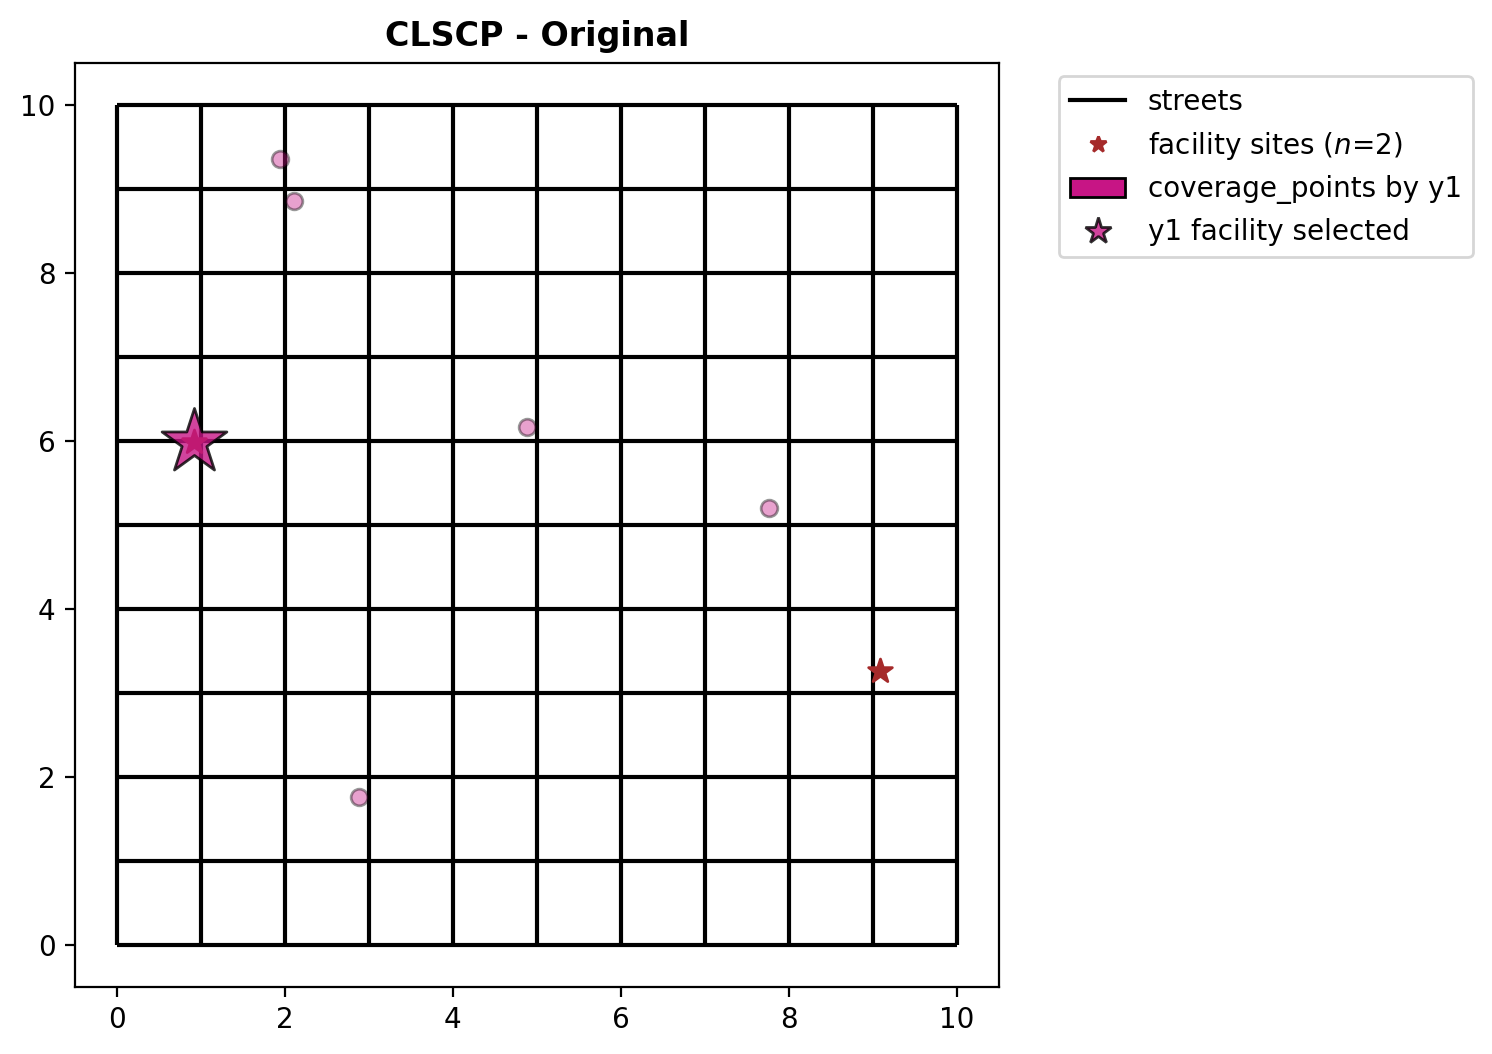

In [23]:
plot_results(lscp_from_cost_matrix, facility_points, "CLSCP - Original")

Below you may notice the plot only shows three demand points; this is because the two other demand points fall outside the 8 meter maximal service distance.

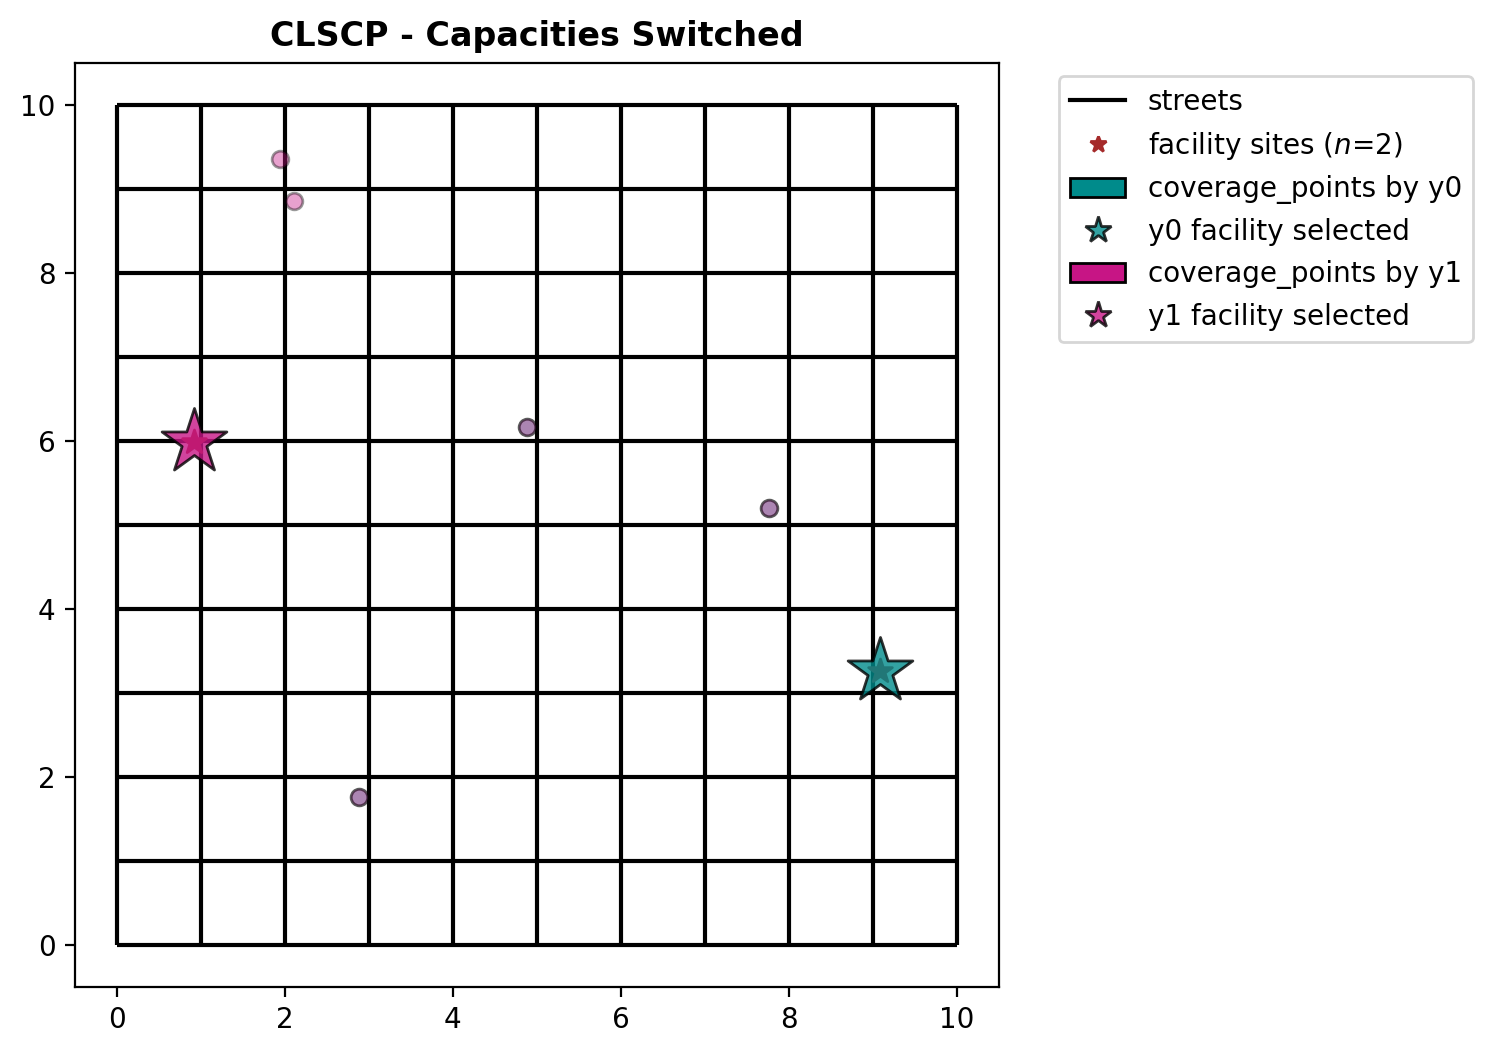

In [24]:
plot_results(lscp_from_cost_matrix_switched, facility_points, "CLSCP - Capacities Switched")

In the "even supply capacity" case, demand nodes are split between facility points to accomodate facility capacity. This means that the two very pink sites on the top left are served exclusively by facility 1, but the three demand sites in the center are served by a mix of facility y1 and y0. 

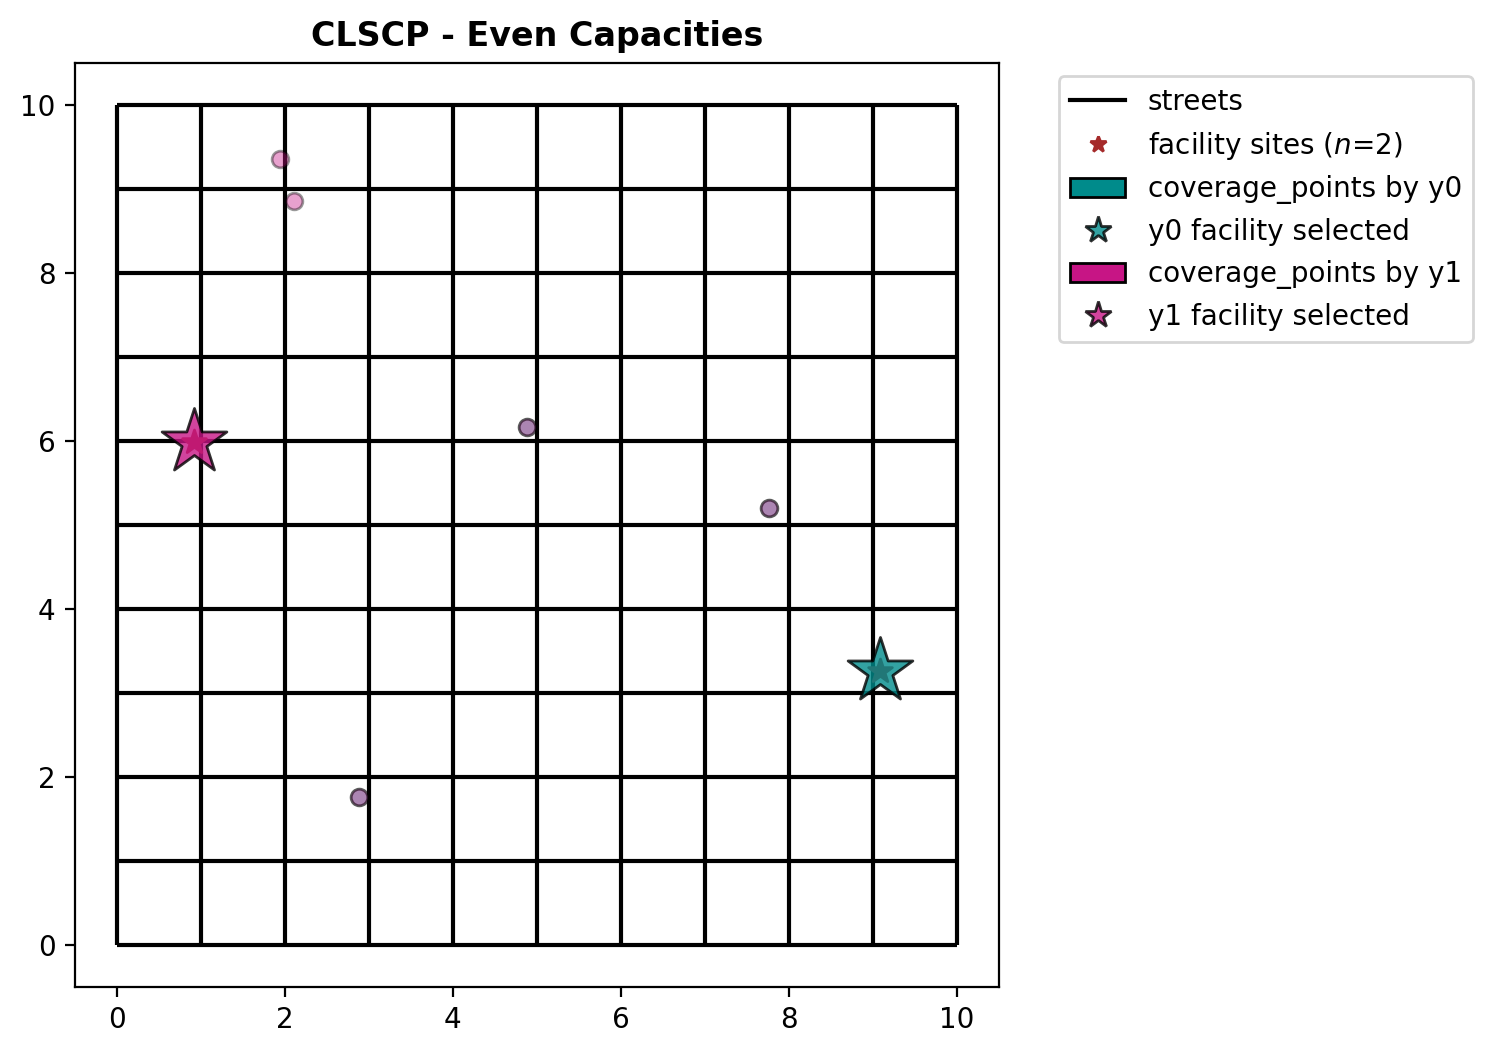

In [25]:
plot_results(lscp_from_cost_matrix_even, facility_points, "CLSCP - Even Capacities")

### LSCP built from geodataframe

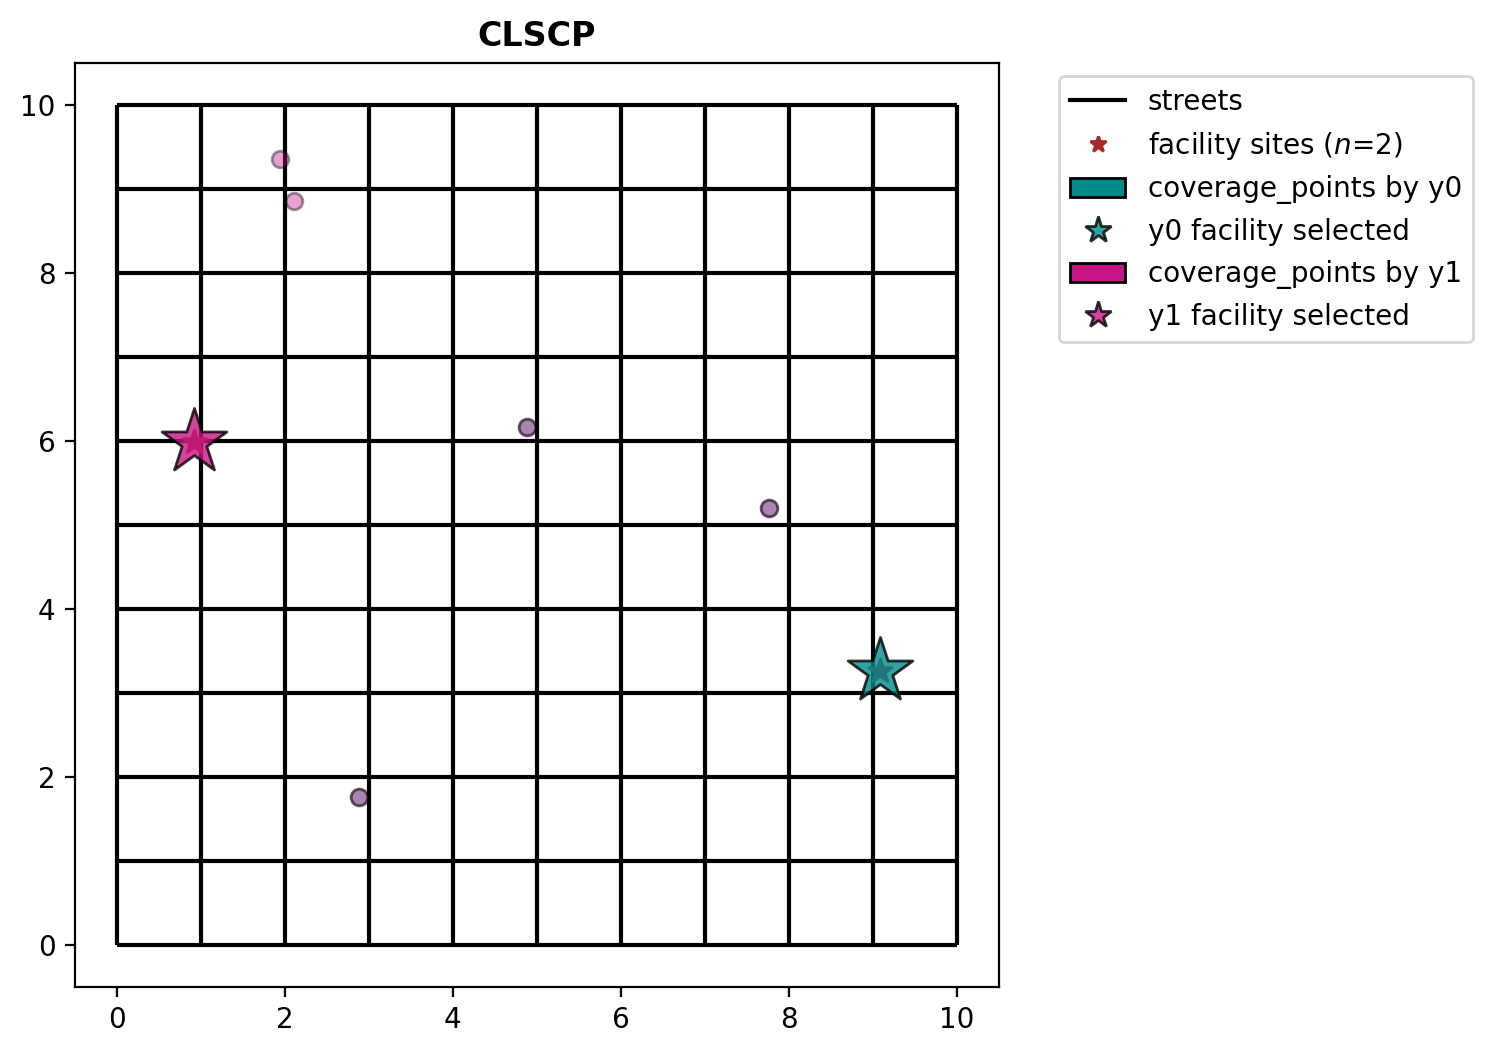

In [26]:
plot_results(lscp_from_geodataframe, facility_points, 'CLSCP')

You may notice that the models are different. This result is expected as the distance between facility and demand points is calculated with different metrics. The cost matrix is calculated with dijkstra distance while the distance using geodataframe is calculated with euclidean distance. 

But why it needs just one facility point to cover all of those demand points? It can be explained by the nature of the problem. The problem was configured in a synthetic manner, the street is created with 10x10 lattice and the max_coverage parameter is 8 meters, so this result is not weird at all. You can change the max_coverage parameter to 2 meters and you will obtain a different result but be aware with how many points will be covered.

### LSCP with preselected facilities

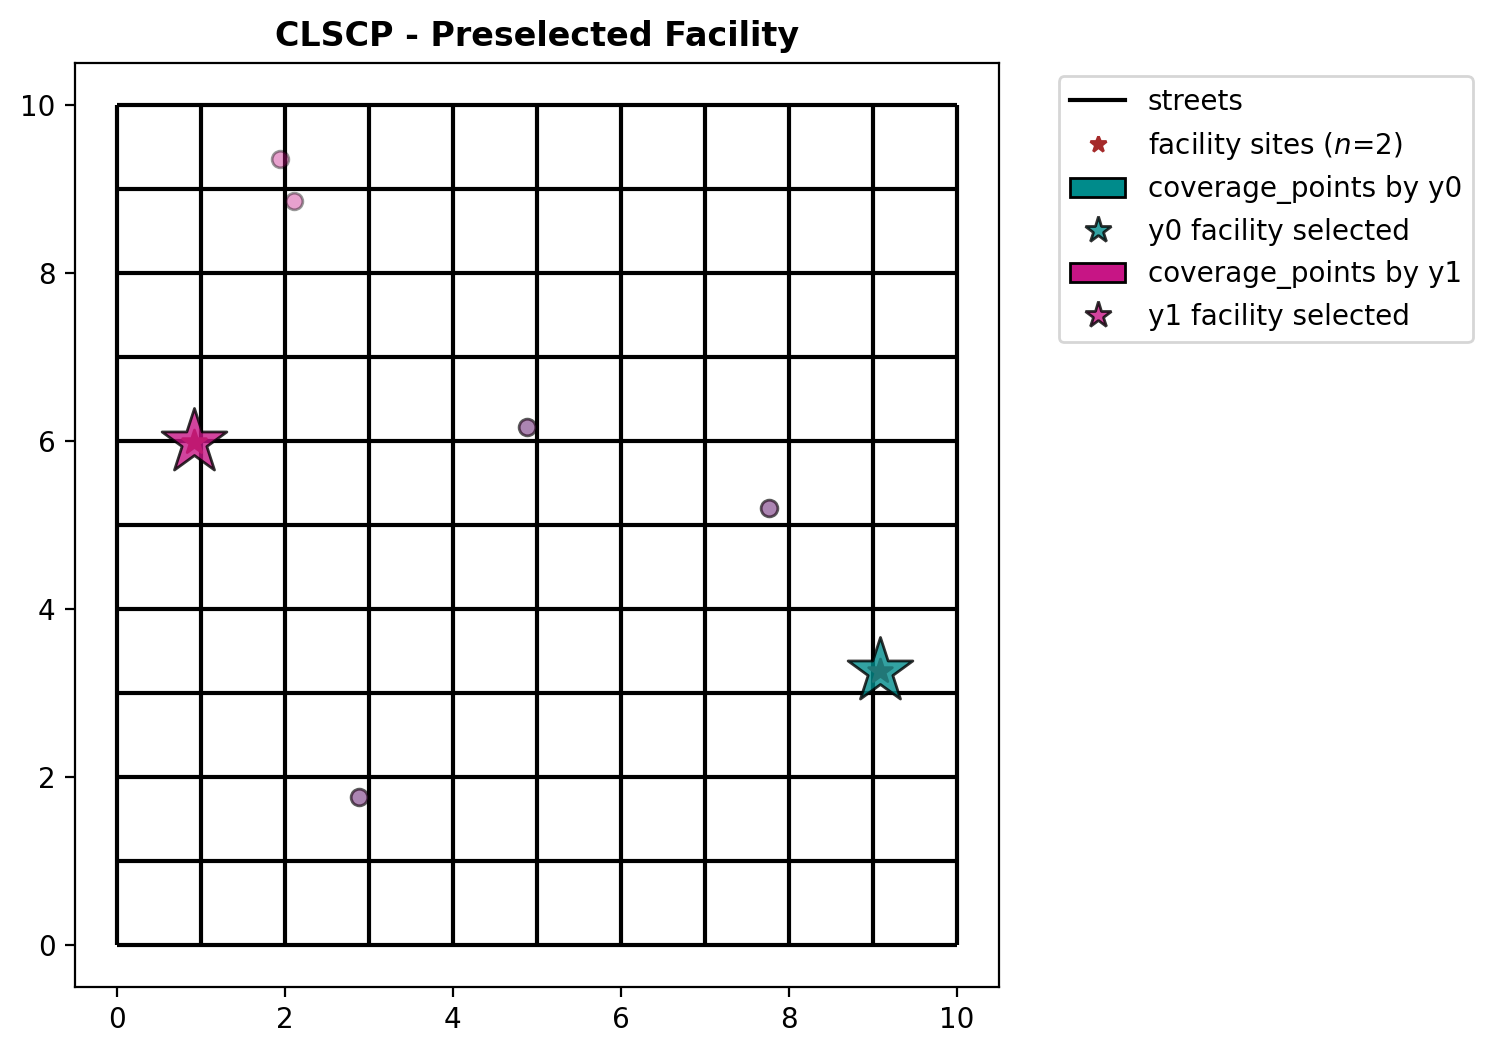

In [27]:
plot_results(lscp_preselected_from_geodataframe, facility_points, 'CLSCP - Preselected Facility')

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)
- [Toregas, C., Swain, R., ReVelle, C., &amp; Bergman, L. (1971). The location of emergency service facilities. Operations Research, 19(6), 1363–1373.](https://pubsonline.informs.org/doi/abs/10.1287/opre.19.6.1363)